## Week 3 Project 2:
## CUNY MSDS DATA620 - Web Analytics
---
### Team5: Christopher Estevez, Meaghan Burke, Rickidon Singh,  Ritesh Lohiya, Rose Koh
### 07/02/2018 (due date)
##### python version: 2.7
---

## Degree and Eigenvector centrality


Project 2

    1.Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
    
    2.Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
    
    3.What can you infer about each of the distinct groups?

## 1. Identify Data:

The group identified data at source: http://konect.uni-koblenz.de/networks/moreno_crime.

Original Source: http://moreno.ss.uci.edu/data.html#crime

**DESCRIPTION** One 870×557 two mode valued matrix of individuals by involvement in crime events. One 870×1 vector displaying the sex of each individual.

CRIME two mode, valued
SEX vector reporting sex of each individual.

**BACKGROUND** In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime. Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual.

## 2. Load & explore the data.

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
%matplotlib inline
from networkx.algorithms import bipartite as bi
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### 2.1 Load & Merge Files: 
  - **crime_df:** "out.moreno_crime" -- The adjacency matrix of the network in space separated values format, with one edge
  - **person_df:** "ent.moreno_crime.person.name" -- Contains the attribute `name` of entity `person` of the network
  - **person_df['SEX']:** "ent.moreno_crime.person.sex" -- Contains the attribute `sex` of entity `person` of the network
  - **all_data_df:** all metadata merged together 
  


In [43]:
data_location = r'C:\Users\TEMP\BI Tech Team\web-analytics-master\project2\Data'

#Loading TSV file
crime_df = pd.read_csv(data_location+"\out.moreno_crime_crime", 
                       delim_whitespace=True, header=None, skiprows=[0,1], 
                       names=['PERSON', 'CRIME'])
#Load role
crime_df['ROLE'] = pd.read_csv(data_location+"\\role.txt", header=None)

#load person information
person_df = pd.read_csv(str(data_location)+"\ent.moreno_crime_crime.person.name", header=None,names=['NAME'])

#added index number that matches person crime number
person_df['PERSON'] = person_df.index.values+1

#sex of person
person_df['SEX'] = pd.read_csv(data_location+"\ent.moreno_crime_crime.person.sex", header=None)
person_df['SEX'].replace({1: 'M', 0: 'F'}, inplace = True)

#merged data from crime data and person

all_data_df = pd.merge(crime_df,person_df, on=['PERSON'],how='outer')

### 2.2 Explore The Data: 
  - Sample the data *.head()*
  - Gather the demographics of each column 
  - Identify the count of names to role\
 
***A name is conncted to a crime as the role of Suspect, Victim, Witness or Victim-Suspect***

In [60]:
all_data_df.head()

,PERSON,CRIME,ROLE,NAME,SEX
0,1,1,Suspect,AbelDennis,M
1,1,2,Victim,AbelDennis,M
2,1,3,Victim,AbelDennis,M
3,1,4,Suspect,AbelDennis,M
4,2,5,Victim,AbramsChad,M


In [61]:
values = [['Unique Names', 'Unique Crimes','Unique Roles'],
          [len(all_data_df.NAME.unique()), 
        len(all_data_df.CRIME.unique()), len(all_data_df.ROLE.unique())]]
headers = values.pop(0)
demographics_df = pd.DataFrame(values,columns = headers)
demographics_df

,Unique Names,Unique Crimes,Unique Roles
0,828,551,4


In [62]:
role_summary = all_data_df.groupby('ROLE').PERSON.count().reset_index()
role_summary

,ROLE,PERSON
0,Suspect,682
1,Victim,558
2,Victim Suspect,41
3,Witness,195


### 2.3 Restructure the Data:
- Save the restructured dataframe to 'crime_df'
- Groupby person & role
    - Calculate the total crime involvement 'TOTAL_CRIME_COUNT'
    - Calculate the total role count 
- Create a dictionary of people to role type


In [72]:
crime_df = all_data_df.copy()
crime_df['TOTAL_ROLE_COUNT'] = crime_df.groupby(['PERSON','ROLE']).CRIME.transform('count')
crime_df['TOTAL_CRIME_COUNT'] = crime_df.groupby(['PERSON']).CRIME.transform('count')


In [73]:
crime_df.head()

,PERSON,CRIME,ROLE,NAME,SEX,TOTAL_ROLE_COUNT,TOTAL_CRIME_COUNT
0,1,1,Suspect,AbelDennis,M,2,4
1,1,2,Victim,AbelDennis,M,2,4
2,1,3,Victim,AbelDennis,M,2,4
3,1,4,Suspect,AbelDennis,M,2,4
4,2,5,Victim,AbramsChad,M,4,22


In [81]:
keys = []
values = []
roles = crime_df['ROLE'].unique().tolist()
for x in roles:
    keys.append(x)
    temp_df = crime_df.loc[crime_df['ROLE'] == x]
    values.append(temp_df['PERSON'].unique().tolist())
role_dict = dict(zip(keys, values))


### 2.4 Plot the Data (Basic):
  - Return a basic graph (G) from Pandas DataFrame containing an edge list. * nx.from_pandas_dataframe()*
  - Print short summary of information for the graph  *nx.info()*
  - Draw the graph G with Matplotlib *nx.draw()*
      - colors represent the role of each node:
          - Magenta: suspect 
          - Green: victim
          - Yellow: all others

In [75]:
G = nx.from_pandas_dataframe(crime_df , 'PERSON','CRIME', edge_attr = ['ROLE','NAME','SEX'],create_using=nx.Graph())

In [87]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 829
Number of edges: 1475
Average degree:   3.5585


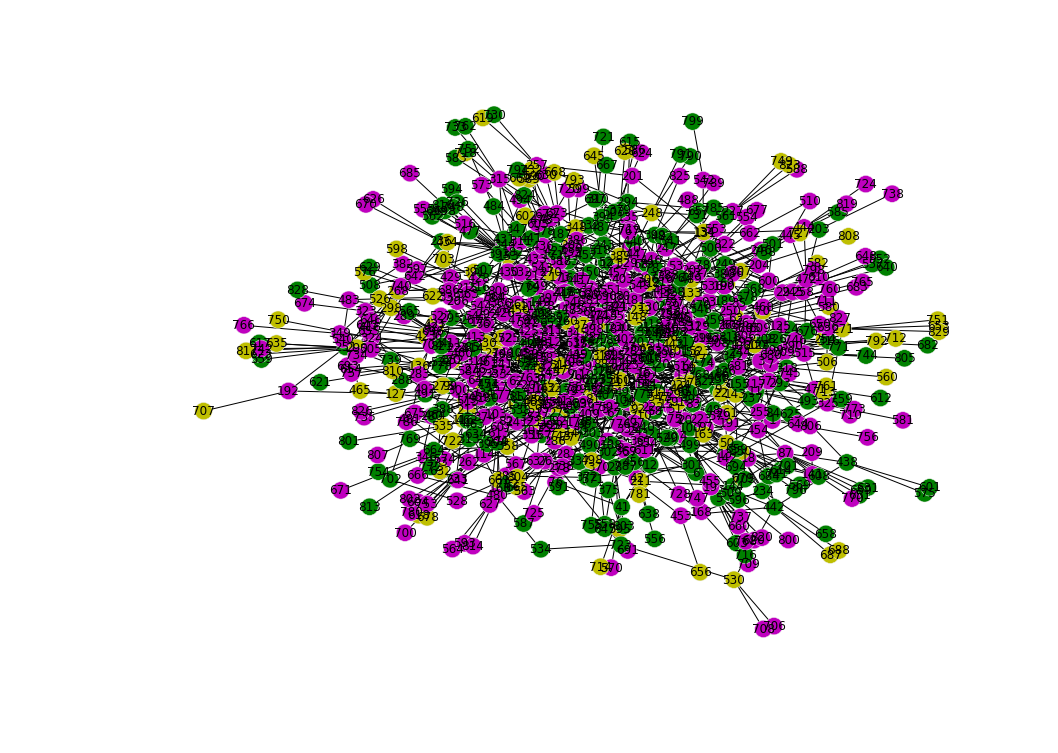

In [88]:
plt.figure(figsize=(14, 10))
color=[]
for x in G.degree().keys():
    if x in role_dict ['Suspect']:
        color.append('m')
    elif x in role_dict['Victim']:
        color.append('g')
    else:
        color.append('y')

nx.draw(G,node_color =color, with_labels=True)
plt.show()

## 3. Bipartite Graph:

### 3.1: Load Network & Examine Network:

- Load in all the nodes & edges manually to ensure that the bipartite structure can be formed from the data 
   - Loop through the newly restructured dataframe to add the "person" nodes 
       - Person
       - Sex
       - Role count (suspect, witness, victim, etc.)
       - Crime involvement count
   - Loop through the dataframe for crime node information
   - Add edges between the person and crime nodes 
   - Confirm if the network is structured correctly
       - **is_connected():** Return True if the graph is connected, false otherwise
       - **is_bipartite():** Returns True if graph G is bipartite, False if not
       - **connected_component_subgraphs():** Network split into components as subgraphs
   - Generate a list of "top_nodes", people, and "bottom_nodes",crime
   - Calculate the degree(): The node degree is the number of edges adjacent to that node
   - Calculate the degree centrality: the fraction of nodes it is connected to
   - Calculate the eigenvector centrality: computes the centrality for a node based on the centrality of its neighbors

In [102]:
crime_df = crime_df[['NAME', 'CRIME', 'ROLE','TOTAL_ROLE_COUNT','TOTAL_CRIME_COUNT','SEX']]

In [103]:
G2 = nx.Graph()
# PERSON NODES
for i in range(len(crime_df)): 
    G2.add_node(crime_df.iloc[i][0],
                ROLE = crime_df.iloc[i][2],
                ROLE_COUNT =crime_df.iloc[i][3],
                CRIME_TOTAL=crime_df.iloc[i][4],
                Sex=crime_df.iloc[i][5],
                bipartite=1)
# CRIME NODES
for i in range(len(crime_df)): 
    G2.add_node(crime_df.iloc[i][1],
                bipartite=0)
# EDGES

for i in range(len(crime_df)):
    G2.add_edge(crime_df.iloc[i][0], crime_df.iloc[i][1], weight=1)

In [110]:
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 1379
Number of edges: 1476
Average degree:   2.1407


In [112]:
# Checking the stucture of the graph- is it bipartite?

values = [['Connection Check', 'Bipartite Check','Total Nodes','Connected Component Subgraphs'],
          [nx.is_connected(G2),nx.is_bipartite(G2),len(G2),len(list(nx.connected_component_subgraphs(G2))) ]]
headers = values.pop(0)
check_df = pd.DataFrame(values,columns = headers)
check_df

,Connection Check,Bipartite Check,Total Nodes,Connected Component Subgraphs
0,False,True,1379,20


In [106]:
top_nodes = set(n for n,d in G2.nodes(data=True) if d['bipartite']==1)
bottom_nodes = set(G2) - top_nodes

In [109]:
d ={'People Nodes': list(top_nodes)[0:10],
 'Crime Nodes': list(bottom_nodes)[0:10]}
nodes_df = pd.DataFrame(data=d)
nodes_df

,Crime Nodes,People Nodes
0,1,ParkerByron
1,2,SargentDaniel
2,3,SmothersFreddie
3,4,CottonJo
4,5,BurnsDarian
5,6,MadisonSonny
6,7,KentonMelba
7,8,BeckerMax
8,9,HoltJuanita
9,10,JamesSara


In [140]:
# The node degree is the number of edges adjacent to that node
degree = G2.degree()
degree_df = pd.DataFrame([degree], columns=degree.keys()).T.reset_index()
degree_df.rename(columns ={0:'Connections','index': 'Nodes'}, inplace = True)
degree_df.sort_values(['Connections'], ascending=False, inplace = True)

In [139]:
degree_df.head()

,Nodes,Connections
1166,WillisJenny,25
662,AbramsChad,22
580,KatzLuella,18
110,110,18
1046,DicksonCarter,17


In [151]:
degree_c = nx.degree_centrality(G2)
degree_c_df = pd.DataFrame([degree_c.values()], columns=degree_c.keys()).T.reset_index()
degree_c_df.rename(columns ={0:'Degree Centrality','index': 'Nodes'}, inplace = True)
degree_c_df.sort_values(['Degree Centrality'], ascending=False, inplace = True)

In [153]:
degree_c_df.head()

,Nodes,Degree Centrality
1166,WillisJenny,0.018142
662,AbramsChad,0.015965
580,KatzLuella,0.013062
110,110,0.013062
1046,DicksonCarter,0.012337


In [158]:
eigenvector_c = nx.eigenvector_centrality_numpy(G2)
eigen_c_df = pd.DataFrame([eigenvector_c.values()], columns=eigenvector_c.keys()).T.reset_index()
eigen_c_df.rename(columns ={0:'Eigenvector Centrality','index': 'Nodes'}, inplace = True)
eigen_c_df.sort_values(['Eigenvector Centrality'], ascending=False, inplace = True)

In [160]:
eigen_c_df.head()

,Nodes,Eigenvector Centrality
110,110,0.414920
580,KatzLuella,0.414200
531,SteinerCatherine,0.247706
95,95,0.233381
855,SmithMichaelThomas,0.220285


### 3.2: Visualize the Network:
- Large network, typically a single person per crime
- Position nodes uniformly at random in the unit square *pos=nx.random_layout(G2)*
- Green nodes are people & cyan nodes are crimes 
- The size of the node is representative of the number of connections *d = G2.degree()*


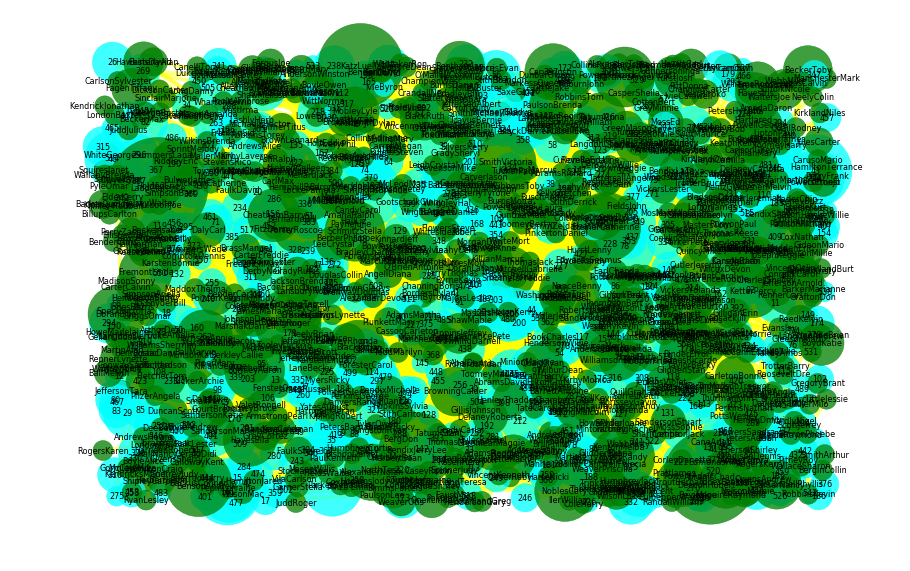

In [38]:
plt.figure(figsize=(14, 10))
pos=nx.random_layout(G2)
g_df =  pd.DataFrame(list(G2.copy().degree()))

colors=[]
for x in g_df[0]:
    if x in top_nodes:
        colors.append('green')
    else:
        colors.append('cyan')
    
# nodes
d = G2.degree()
nx.draw_networkx_nodes(G2,pos, node_color=colors, node_size=[v*400 for v in d.values()], alpha=0.75)
# edges
nx.draw_networkx_edges(G2,pos, width=4,alpha=0.5,edge_color='yellow',style='solid')
nx.draw_networkx_labels(G2,pos, font_size=8, font_family='sans-serif')

plt.axis('off')
plt.show()

### 3.3: Island Analysis- *Kouznetsov & Tsvetovat*:
- Implemented the island_method() and trim_edges() functions from **Social Network Analysus For Startups**
    - *the island method is a function to virtually raise the water level. The function below takes a graph, and applies a threshold (“water level”), letting all edges above a certain value through, and removing all others.*
    - Weights are the shared edges 
    - Apply the island mehtod to the biggest component of the bipartite graph
        - top_nodes_nx = nx.bipartite.weighted_projected_graph(G2, top_nodes)
            - isolate the top nodes, more managable dataset
            - examine the subset 
        - cc = list(nx.connected_component_subgraphs(top_nodes_nx ))[0]
    - Examine the output of the island method 
    - Plot the network at various thresholds
      - colors represent the role of each node:
          - Magenta: suspect 
          - Green: victim
          - Yellow: all others

In [165]:
##From TEXTBOOK pg. 64
def trim_edges(g, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [166]:
top_nodes_nx = nx.bipartite.weighted_projected_graph(G2, top_nodes)
cc = list(nx.connected_component_subgraphs(top_nodes_nx ))[0]

In [179]:
print(nx.info(top_nodes_nx))

Name: 
Type: Graph
Number of nodes: 828
Number of edges: 2253
Average degree:   5.4420


In [167]:
values = [['Threshold','Number of People', 'Connection Number']]
islands = island_method(cc, iterations = 4)
for x in islands:
    threshold =x[0]
    num_people = len(x[1])
    connections = len(list(nx.connected_component_subgraphs(x[1])))
    temp_list = [threshold, num_people, connections]
    values.append(temp_list)
    
headers = values.pop(0)
islan_df = pd.DataFrame(values,columns = headers)

In [168]:
islan_df

,Threshold,Number of People,Connection Number
0,1,89,27
1,2,28,12
2,3,15,7
3,4,6,3


In [169]:
keys = []
values = []
roles = crime_df['ROLE'].unique().tolist()
for x in roles:
    keys.append(x)
    temp_df = crime_df.loc[crime_df['ROLE'] == x]
    values.append(temp_df['NAME'].unique().tolist())
role_dict = dict(zip(keys, values))

#### Threshold 1:

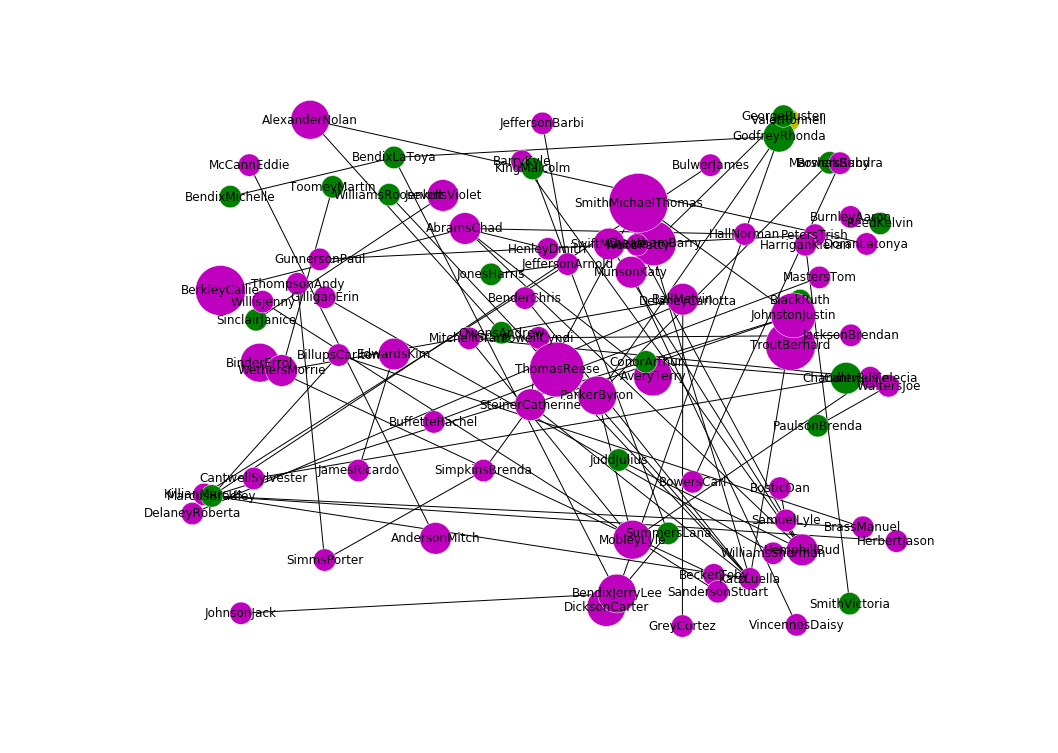

In [190]:
plt.figure(figsize=(14, 10))
island_plot = trim_edges(cc, 1)
pos=nx.random_layout(island_plot)

color=[]
for x in island_plot.degree(top_nodes).keys():
    if x in role_dict ['Suspect']:
        color.append('m')
    elif x in role_dict['Victim']:
        color.append('g')
    else:
        color.append('y')
d_island =island_plot.degree()

nx.draw_random(island_plot,node_size=[v*500 for v in d_island.values()],node_color =color, with_labels=True)
plt.axis('off')
plt.show()

#### Threshold 2:

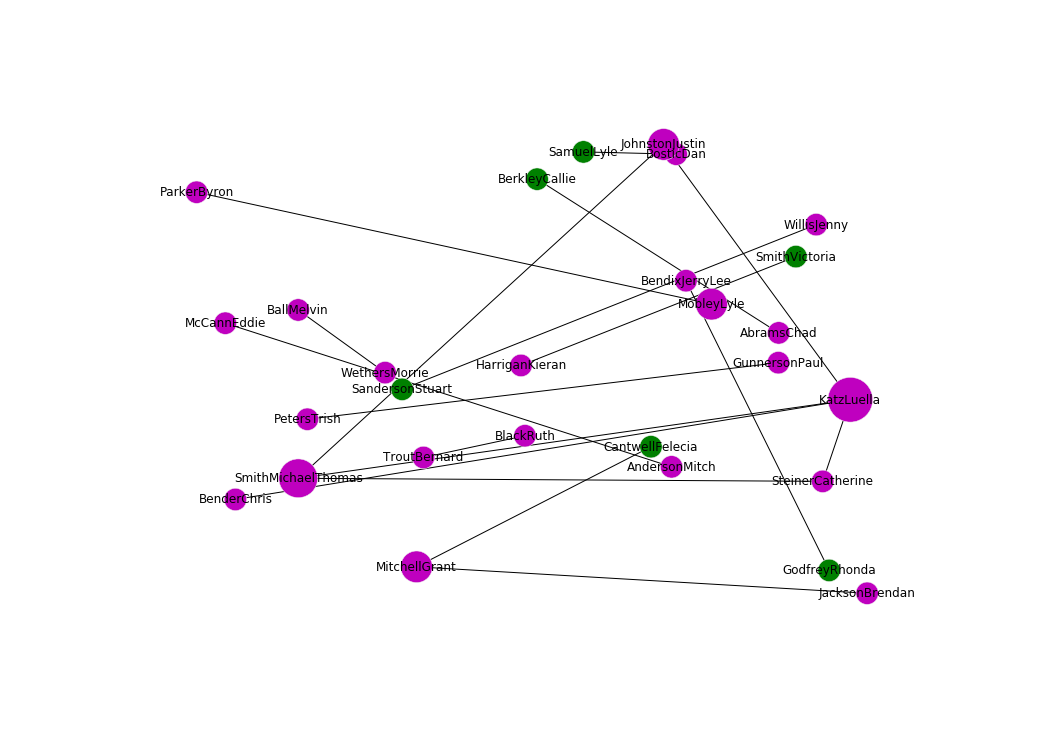

In [176]:
plt.figure(figsize=(14, 10))
island_plot = trim_edges(cc, 2)
pos=nx.random_layout(island_plot)

color=[]
for x in island_plot.degree(top_nodes).keys():
    if x in role_dict ['Suspect']:
        color.append('m')
    elif x in role_dict['Victim']:
        color.append('g')
    else:
        color.append('y')
d_island =island_plot.degree()

nx.draw_random(island_plot,node_size=[v*500 for v in d_island.values()],node_color =color, with_labels=True)
plt.axis('off')
plt.show()

### 3.4: Node Specific Analysis:
- top_nodes_nx = nx.bipartite.weighted_projected_graph(G2, top_nodes)
- Draw the egonetworks for SmithMichaelThomas

In [200]:
# The node degree is the number of edges adjacent to that node
top_node_degree = top_nodes_nx.degree()
top_node_degree = pd.DataFrame([degree], columns=degree.keys()).T.reset_index()
top_node_degree.rename(columns ={0:'Connections','index': 'Nodes'}, inplace = True)
top_node_degree.sort_values(['Connections'], ascending=False, inplace = True)
top_node_degree.head()

,Nodes,Connections
324,KatzLuella,51
618,AbramsChad,48
29,HemphillBud,44
819,BendixJerryLee,33
415,SmithMichaelThomas,33


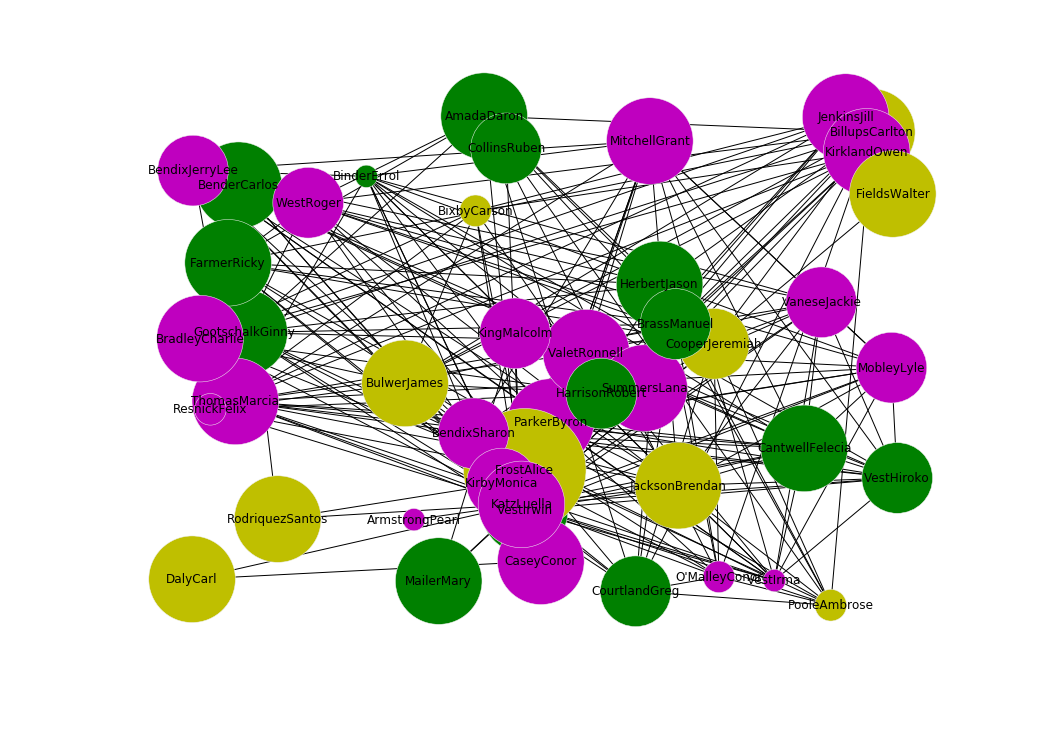

In [201]:
plt.figure(figsize=(14, 10))
SmithMichaelThomas = nx.ego_graph(top_nodes_nx, 'SmithMichaelThomas', radius=1, center=True, undirected=True, distance='weight')

color=[]
for x in top_nodes_nx.degree(top_nodes).keys():
    if x in role_dict ['Suspect']:
        color.append('m')
    elif x in role_dict['Victim']:
        color.append('g')
    else:
        color.append('y')
        
d_test=SmithMichaelThomas.degree()


nx.draw_random(test,node_size=[v*500 for v in d_test.values()],node_color =color, with_labels=True)

plt.axis('off')
plt.show()

## Sources

http://www.datasciencemadesimple.com/join-merge-data-frames-pandas-python/